# DataMole Air Pressure Assignment
Working on air pump failures
- Since we are predicting pump failures this is a classification problem. 
- First lets load and look at the data

In [250]:
import pandas as pd
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [251]:
pq_raw_data = pq.read_table('data/data.parquet')

In [252]:
df = pq_raw_data.to_pandas()

In [253]:
df.head(5)

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


In [255]:
print(f'Machine ID null sum: {df.MachineId.isnull().sum()}')
print(f'Measurement ID null sum: {df.MeasurementId.isnull().sum()}')
print(f'Pressure null sum: {df.Pressure.isnull().sum()}')

Machine ID null sum: 0
Measurement ID null sum: 0
Pressure null sum: 0


In [256]:
df.Pressure.describe()

count    1.846636e+07
mean     3.338926e-01
std      4.862787e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.017707e-01
max      6.774464e+00
Name: Pressure, dtype: float64

In [257]:
# First lets merge the machine id and measurement id columns to iterate over
df['cycle_code'] = df['MachineId'] + '_' + df['MeasurementId'].astype(str)

In [258]:
df.head()

,MachineId,MeasurementId,Pressure,cycle_code
0,0_0_0,0,0.0,0_0_0_0
1,0_0_0,0,0.0,0_0_0_0
2,0_0_0,0,0.0,0_0_0_0
3,0_0_0,0,0.0,0_0_0_0
4,0_0_0,0,0.0,0_0_0_0


So there are many 0 values, which could be from before the machine begins its cycle. The mean is 0.334. There could be some outliers in the max values as the max value is much larger than the 75% value but since we are going to be computing variables out of this data, these can be ignored for now. 

In [259]:
labels = pd.read_csv('data/labels.csv')

In [260]:
labels.head(10)

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
5,0_1_1,1,True,False,False
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
8,1_0_0,2,False,True,False
9,1_0_1,-1,NaN,NaN,NaN


In [261]:
labels['cycle_code'] = labels['MachineId'] + '_' + labels['MeasurementId'].astype(str)

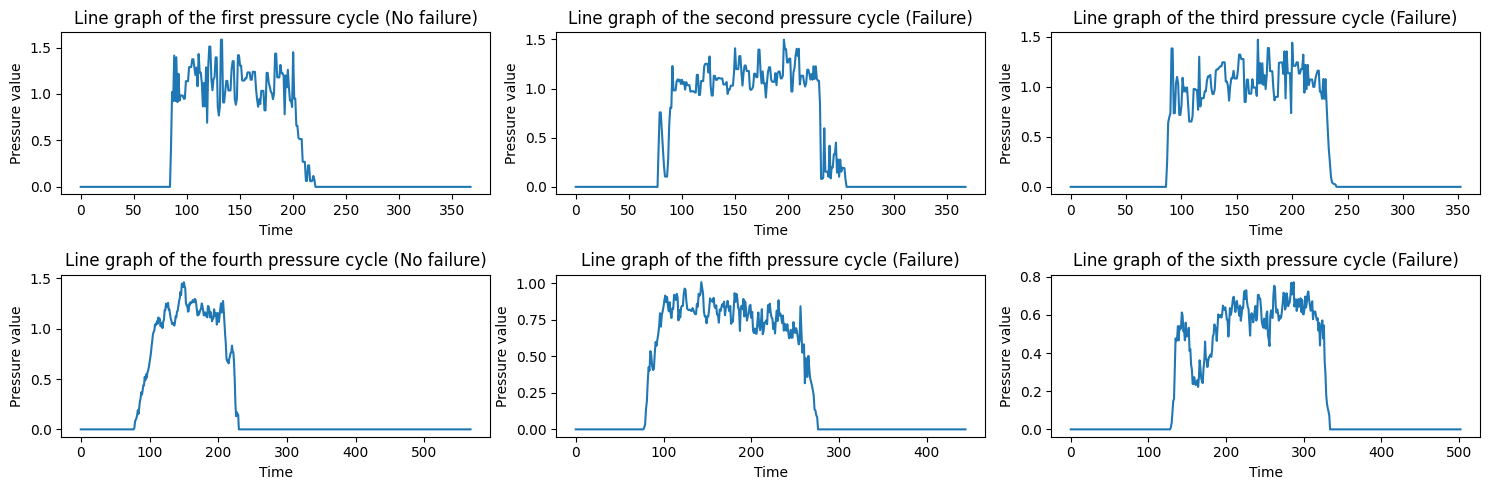

In [339]:
# Create a figure and six subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df[(df['cycle_code'] == '0_0_0_0')]
axes[0, 0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0, 0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Pressure value')

# Access the second subplot
second_cycle = df[(df['cycle_code'] == '0_0_3_0')]
axes[0, 1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[0, 1].set_title('Line graph of the second pressure cycle (Failure)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Pressure value')

# Access the third subplot
third_cycle = df[(df['cycle_code'] == '0_1_1_1')]
axes[0, 2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[0, 2].set_title('Line graph of the third pressure cycle (Failure)')
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Pressure value')

# Access the fourth subplot
four_cycle = df[(df['cycle_code'] == '1_0_0_2')]
axes[1, 0].plot(range(len(four_cycle)), four_cycle['Pressure'])
axes[1, 0].set_title('Line graph of the fourth pressure cycle (No failure)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Pressure value')

# Access the fifth subplot
five_cycle = df[(df['cycle_code'] == '1_2_2_4')]
axes[1, 1].plot(range(len(five_cycle)), five_cycle['Pressure'])
axes[1, 1].set_title('Line graph of the fifth pressure cycle (Failure)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure value')

# Access the sixth subplot
six_cycle = df[(df['cycle_code'] == '2_2_2_3')]
axes[1, 2].plot(range(len(six_cycle)), six_cycle['Pressure'])
axes[1, 2].set_title('Line graph of the sixth pressure cycle (Failure)')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The pressure values look sorted. 
There are many zeros at the beginning and end of the machine cycle. A large drop at the beginning of the cycle indicates a failure.

In [263]:
#First lets see how many pressure values are measured per cycle
pressure_count = df.groupby('cycle_code')['Pressure'].count().reset_index()
pressure_count.columns = ['cycle_code', 'pressure_count']

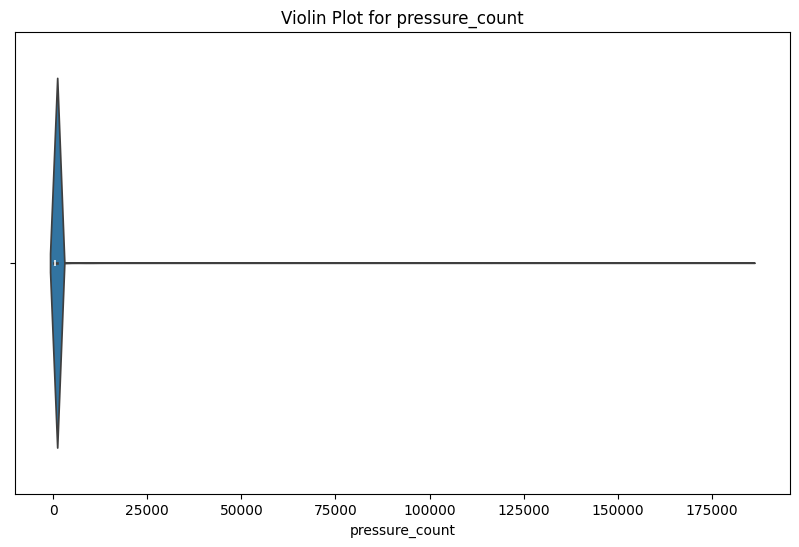

In [264]:
# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='pressure_count', data=pressure_count)
plt.title('Violin Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

In [265]:
df['MachineId'] = df['MachineId'].astype('category')
df['MeasurementId'] = df['MeasurementId'].astype('category')
df['Pressure'] = df['Pressure'].astype('float32')

In [266]:
def del_lead_trail_zeros(cycle):
    # Find the indices of non-zero values
    non_zero_indices = cycle.index[cycle['Pressure'] != 0]

    if len(non_zero_indices) > 0:
        # Find the first and last non-zero indices
        start_index = non_zero_indices[0]
        end_index = non_zero_indices[-1]

        # Slice the DataFrame to keep all values between the first and last non-zero values
        mach_cycle = cycle.loc[start_index:end_index + 1]

        return mach_cycle
    else:
        # If there are no non-zero values, return an empty DataFrame
        return pd.DataFrame(columns=cycle.columns)

In [267]:
df_cleaned = df.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)

C:\Users\mslam\AppData\Local\Temp\ipykernel_25848\420724946.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cleaned = df.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)
C:\Users\mslam\AppData\Local\Temp\ipykernel_25848\420724946.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cleaned = df.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)


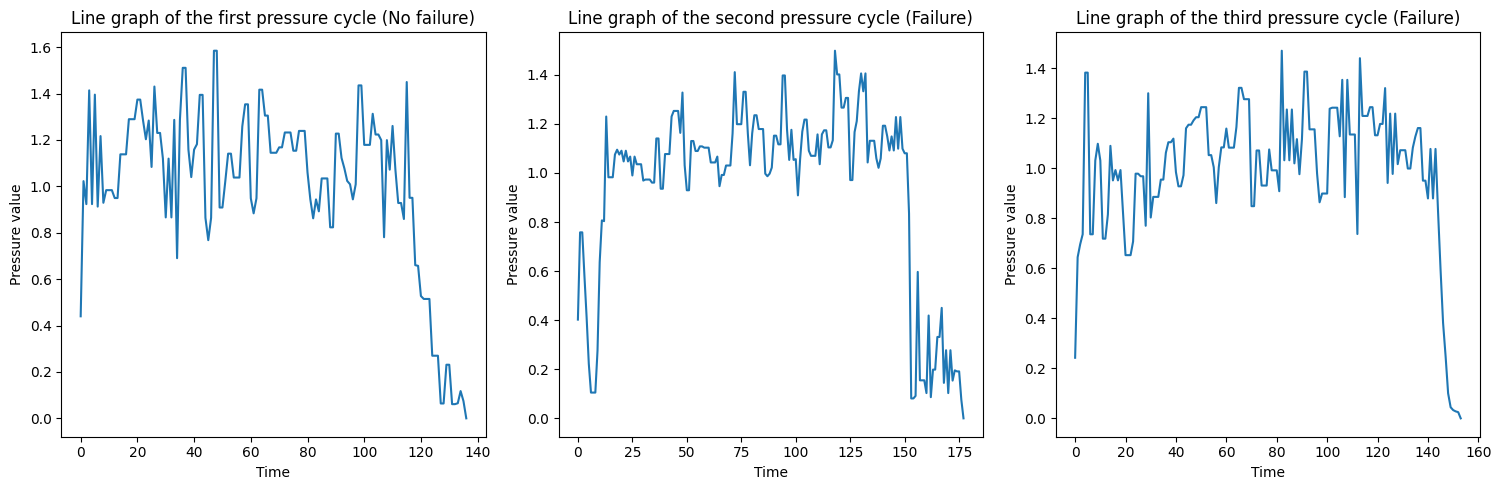

In [327]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_0_0_0')]
axes[0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Pressure value')

second_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_0_3_0')]
axes[1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[1].set_title('Line graph of the second pressure cycle (Failure)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Pressure value')

third_cycle = df_cleaned[(df_cleaned['cycle_code'] == '0_1_1_1')]
axes[2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[2].set_title('Line graph of the third pressure cycle (Failure)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

That is looking much better, the leading and trialing zeros have been deleted

In [269]:
#Lets see how many pressure values are measured per cycle, as there could be some 
# measurements that carried on for a long time (as in were left running)
pres_count = df_cleaned.groupby('cycle_code')['Pressure'].count().reset_index()
pres_count.columns = ['cycle_code', 'pressure_count']

In [270]:
pres_count.pressure_count.describe()

count     27311.000000
mean        389.930687
std        3642.889256
min           2.000000
25%         143.000000
50%         188.000000
75%         251.000000
max      183492.000000
Name: pressure_count, dtype: float64

Something weird is happening here. It seems that many of the pressure cycles are still long even after deleting the zeros. The pressure gauge could have been left on and therefore the leading and trialing zero function failed to delete the counts. So we can delete the cycles will over 300 pressure measurements. 

In [271]:
count = df_cleaned.groupby('cycle_code')['Pressure'].count().reset_index()
count.columns = ['cycle_code', 'pressure_count']
high_cycle = count.loc[count['pressure_count'] > 300, 'cycle_code']
pressure_count_filtered = count[~count['cycle_code'].isin(high_cycle)]
#Creating a new df without the cycles that are over 300 measurements long.
df_filtered = df_cleaned[~df_cleaned['cycle_code'].isin(high_cycle)]
#Also delete the rows from the labels df
labels = labels[~labels['cycle_code'].isin(high_cycle)]

In [272]:
new_count = df_filtered.groupby('cycle_code')['Pressure'].count().reset_index()
new_count.columns = ['cycle_code', 'pressure_count']

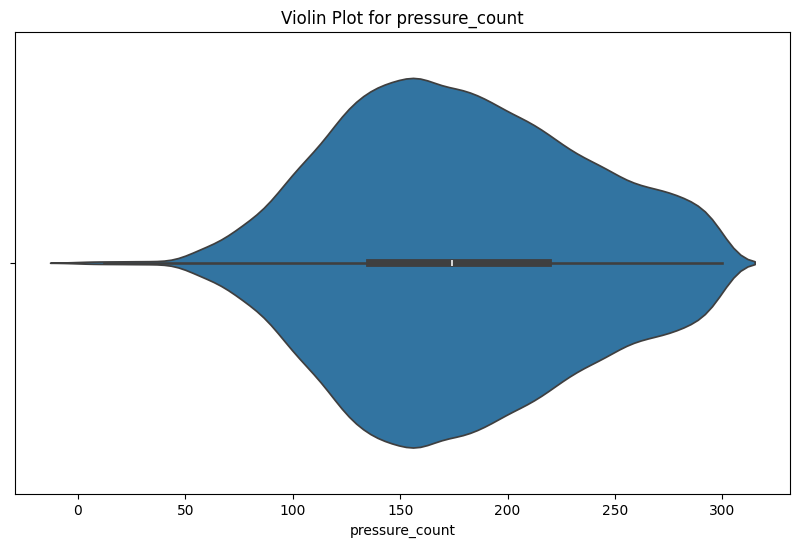

In [273]:
# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='pressure_count', data=new_count)
plt.title('Violin Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

That looks like a much better distribution. Now lets get a baseline for the model. A basic logistic regression, a random forest, and a KNN will be used. We wont use SVM as it will take a long time to run. This is a binary classification problem. We will delete the cycle_codes, machine id and measurement id as they could be considered data leakage and will not carry valuable information when the model is applied to another set of machines. Next we need to deal with missing data. 

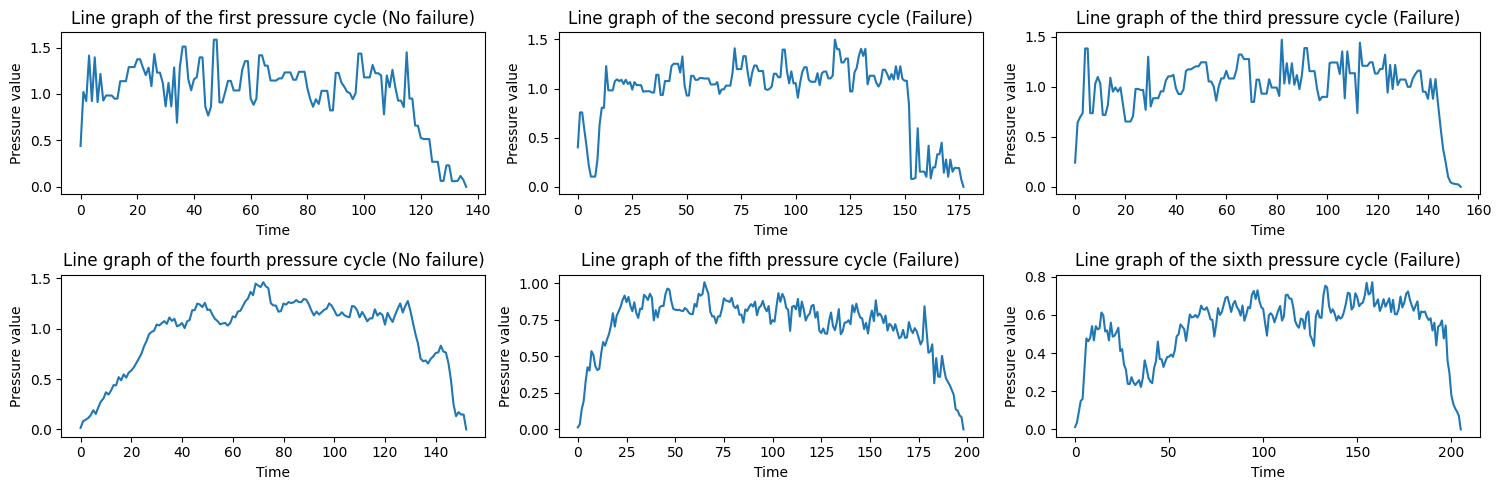

In [341]:
# Create a figure and six subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = df_filtered[(df_filtered['cycle_code'] == '0_0_0_0')]
axes[0, 0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0, 0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Pressure value')

# Access the second subplot
second_cycle = df_filtered[(df_filtered['cycle_code'] == '0_0_3_0')]
axes[0, 1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[0, 1].set_title('Line graph of the second pressure cycle (Failure)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Pressure value')

# Access the third subplot
third_cycle = df_filtered[(df_filtered['cycle_code'] == '0_1_1_1')]
axes[0, 2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[0, 2].set_title('Line graph of the third pressure cycle (Failure)')
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Pressure value')

# Access the fourth subplot
four_cycle = df_filtered[(df_filtered['cycle_code'] == '1_0_0_2')]
axes[1, 0].plot(range(len(four_cycle)), four_cycle['Pressure'])
axes[1, 0].set_title('Line graph of the fourth pressure cycle (No failure)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Pressure value')

# Access the fifth subplot
five_cycle = df_filtered[(df_filtered['cycle_code'] == '1_2_2_4')]
axes[1, 1].plot(range(len(five_cycle)), five_cycle['Pressure'])
axes[1, 1].set_title('Line graph of the fifth pressure cycle (Failure)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure value')

# Access the sixth subplot
six_cycle = df_filtered[(df_filtered['cycle_code'] == '2_2_2_3')]
axes[1, 2].plot(range(len(six_cycle)), six_cycle['Pressure'])
axes[1, 2].set_title('Line graph of the sixth pressure cycle (Failure)')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



In [274]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [275]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23432 entries, 0 to 27384
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      23432 non-null  object
 1   MeasurementId  23432 non-null  int64 
 2   PumpFailed     23254 non-null  object
 3   SlowStart      16696 non-null  object
 4   SlowEnd        16696 non-null  object
 5   cycle_code     23432 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB


In [276]:
#delete na values in PumpFailed, SlowStart, and SlowEnd
labels.dropna(subset=['PumpFailed'], inplace = True)
labels.dropna(subset=['SlowStart'], inplace = True)
labels.dropna(subset=['SlowEnd'], inplace = True)
# Convert 'PumpFailed' to integer (0 or 1)
labels['PumpFailed'] = labels['PumpFailed'].astype(int)


In [277]:
y.info()

<class 'pandas.core.series.Series'>
Index: 16696 entries, 0 to 27384
Series name: PumpFailed
Non-Null Count  Dtype
--------------  -----
16696 non-null  int32
dtypes: int32(1)
memory usage: 195.7 KB


In [278]:
X = labels.drop(columns=['PumpFailed', 'cycle_code', 'MachineId', 'MeasurementId'])
y = labels['PumpFailed']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [279]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [391]:
def eval_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate the performance of a classification model.

    Parameters:
    - model: a classifier model
    - X_train, X_test: Testing features
    - y_train, y_test: Target variables

    Returns:
    - recall: Recall score
    - precision: Precision score
    - f1: F1 score
    - auc_roc: AUC-ROC score
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities for positive class
    y_probs = model.predict_proba(X_test)[:, 1]

    # Predict binary outcomes
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probs)

    return model, recall, precision, f1, auc_roc

In [281]:
model, recall, precision, f1, auc_roc = eval_model(RandomForestClassifier(random_state=1), X_train, X_test, y_train, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: RandomForestClassifier(random_state=1)
Recall: 0.00
Precision: 0.00
F1 Score: 0.00
AUC-ROC Score: 0.64


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [282]:
mean_vals = df_filtered.groupby('cycle_code')['Pressure'].mean().reset_index()
mean_vals.columns = ['cycle_code', 'mean_pressure']
std_vals = df_filtered.groupby('cycle_code')['Pressure'].std().reset_index()
std_vals.columns = ['cycle_code', 'std_pressure']
max_vals = df_filtered.groupby('cycle_code')['Pressure'].max().reset_index()
max_vals.columns = ['cycle_code', 'max_pressure']
skew_vals = df_filtered.groupby('cycle_code')['Pressure'].skew().reset_index()
skew_vals.columns = ['cycle_code', 'skewness']

In [283]:
#And add them to the labels col
labels = pd.merge(labels, mean_vals, on='cycle_code', how='left')
labels = pd.merge(labels, std_vals, on='cycle_code', how='left')
labels = pd.merge(labels, max_vals, on='cycle_code', how='left')
labels = pd.merge(labels, skew_vals, on='cycle_code', how='left')

In [426]:
#Kurtosis
kurt_vals = df_filtered.groupby('cycle_code')['Pressure'].apply(lambda x: x.kurtosis()).reset_index()
kurt_vals.columns = ['cycle_code', 'kurtosis']
labels = pd.merge(labels, kurt_vals, on='cycle_code', how='left')

In [473]:
# Calculate the variance for each cycle_code
variance_vals = df_filtered.groupby('cycle_code')['Pressure'].apply(lambda x: x.var()).reset_index()
variance_vals.columns = ['cycle_code', 'variance']
labels = pd.merge(labels, variance_vals, on='cycle_code', how='left')

In [284]:
count_vals = df_filtered.groupby('cycle_code')['Pressure'].count().reset_index()
count_vals.columns = ['cycle_code', 'measurement_count']
labels = pd.merge(labels, count_vals, on='cycle_code', how='left')

In [287]:
#Lets calculate some more metrics
# Function to calculate mean pressure drop for the first half
def mean_pressure_drop(cycle):
    total_measurements = len(cycle)
    first_half_measurements = total_measurements // 2
    
    # Sort the cycle by pressure measurements
    cycle = cycle.sort_values(by='Pressure')

    # Calculate the mean pressure for the first half
    mean_pressure_first_half = cycle.head(first_half_measurements)['Pressure'].mean()

    # Calculate the mean pressure for the entire cycle
    mean_pressure_full_cycle = cycle['Pressure'].mean()

    return mean_pressure_full_cycle - mean_pressure_first_half

In [288]:
# Apply the function to each cycle
result = df_filtered.groupby('cycle_code').apply(mean_pressure_drop).reset_index()
result.columns = ['cycle_code', 'Mean_Pressure_Drop']
labels = pd.merge(labels, result, on='cycle_code', how='left')

In [312]:
# Assuming df_filtered already exists and is loaded
df_filtered.loc[:, 'pressure_drop'] = (
    df_filtered.groupby('cycle_code')['Pressure']
    .diff()
)

In [323]:
def calculate_first_drop_length(df):
    first_drop_length = []
    in_drop = False
    length = 0

    for pressure_drop in df['pressure_drop']:
        if pressure_drop < 0:
            in_drop = True
            length += 1
        elif in_drop:
            break

    return length

In [324]:
# Apply the function to each cycle
result_1 = df_filtered.groupby('cycle_code').apply(calculate_first_drop_length).reset_index()
result_1.columns = ['cycle_code', 'First_Drop_length']
labels = pd.merge(labels, result_1, on='cycle_code', how='left')

In [333]:
def calculate_total_first_drop(df):
    total_drop = 0
    in_drop = False

    for pressure_drop in df['pressure_drop']:
        if pressure_drop < 0:
            in_drop = True
            total_drop += pressure_drop
        elif in_drop:
            break

    return total_drop

In [334]:
# Apply the function to each cycle
result_total_drop = df_filtered.groupby('cycle_code').apply(calculate_total_first_drop).reset_index()
result_total_drop.columns = ['cycle_code', 'Total_First_Drop']
labels = pd.merge(labels, result_total_drop, on='cycle_code', how='left')

In [370]:
def half_drop_metric(df_filtered):
    # Find the index corresponding to the middle of the cycle
    middle_index = len(df_filtered) // 2

    # Get the maximum pressure value in the first half
    max_pressure_first_half = df_filtered['Pressure'][:middle_index].max()

    # Find the minimum pressure in the second half
    min_pressure_second_half = df_filtered['Pressure'][middle_index:].min()

    # Calculate the difference between max and min pressure values
    pressure_difference = max_pressure_first_half - min_pressure_second_half

    return pressure_difference

# Apply the function to each cycle
result_drop_metric = df_filtered.groupby('cycle_code').apply(half_drop_metric).reset_index()
result_drop_metric.columns = ['cycle_code', 'half_drop']
labels = pd.merge(labels, result_drop_metric, on='cycle_code', how='left')


In [366]:
# Apply the function to each cycle
result_drop_metric = df_filtered.groupby('cycle_code').apply(half_drop_metric).reset_index()
result_drop_metric.columns = ['cycle_code', 'half_drop']
labels = pd.merge(labels, result_drop_metric, on='cycle_code', how='left')

In [466]:
def temporary_pressure_drop(df):
    # Define a threshold for pressure drop
    threshold = 1  # You can adjust this value based on your data

    # Check if there's a pressure drop of 0.5 or more in the first half of the cycle
    first_half = df['Pressure'][:len(df) // 2]
    temp_drop = first_half.max() - first_half.min()

    # Return 1 if there's a significant drop, else 0
    return 1 if temp_drop >= threshold else 0

# Apply the function to each cycle_code
labels['temp_pressure_drop'] = df_filtered.groupby('cycle_code').apply(temporary_pressure_drop).reset_index()[0]



In [472]:
labels.drop(columns=['temp_pressure_drop'], inplace=True)

In [467]:
labels.temp_pressure_drop.sum()

11664

In [468]:
labels.head()

,PumpFailed,SlowStart,SlowEnd,cycle_code,mean_pressure,std_pressure,max_pressure,skewness,measurement_count,Mean_Pressure_Drop,First_Drop_length,Total_First_Drop,half_drop,kurtosis,temp_pressure_drop
0,0,False,False,0_0_0_0,1.007498,0.359323,1.584466,-1.240732,137.0,0.259925,1.0,-0.099029,1.584466,1.180795,1
1,0,False,False,0_0_2_0,0.816805,0.196422,1.205104,-1.519446,200.0,0.137561,1.0,-0.215501,1.205104,4.462522,1
2,1,False,False,0_0_3_0,0.943476,0.373409,1.497921,-1.308681,178.0,0.243599,4.0,-0.652807,1.410603,0.489790,0
3,1,False,False,0_1_1_1,0.994390,0.283281,1.470103,-1.662387,154.0,0.193520,1.0,-0.646392,1.382474,3.590352,1
4,0,True,False,1_0_0_2,0.954693,0.366179,1.462193,-1.130646,153.0,0.265147,1.0,-0.036862,1.462193,0.186724,1


In [218]:
labels = labels.drop(['MachineId', 'MeasurementId'], axis=1)

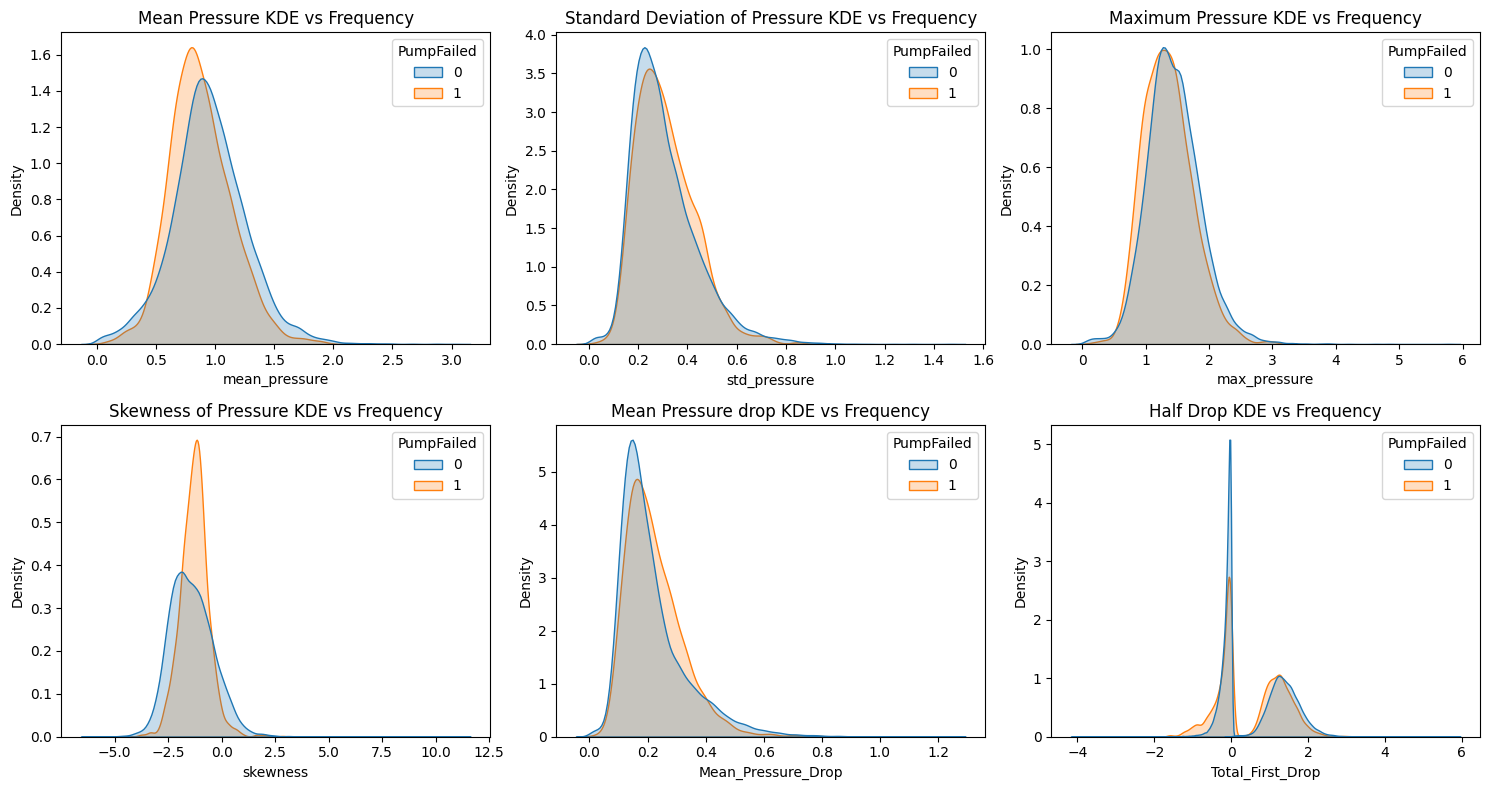

In [374]:
# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot Mean Pressure KDE against Frequency
sns.kdeplot(data=labels, x='mean_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 0])
axes[0, 0].set_title('Mean Pressure KDE vs Frequency')

# Plot Standard Deviation of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='std_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 1])
axes[0, 1].set_title('Standard Deviation of Pressure KDE vs Frequency')

# Plot Maximum Pressure KDE against Frequency
sns.kdeplot(data=labels, x='max_pressure', hue='PumpFailed', fill=True, common_norm=False, ax=axes[0, 2])
axes[0, 2].set_title('Maximum Pressure KDE vs Frequency')

# Plot Skewness of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='skewness', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 0])
axes[1, 0].set_title('Skewness of Pressure KDE vs Frequency')

# Plot Mean pressure drop of Pressure KDE against Frequency
sns.kdeplot(data=labels, x='Mean_Pressure_Drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 1])
axes[1, 1].set_title('Mean Pressure drop KDE vs Frequency')

# Plot Total First Drop KDE against Frequency
sns.kdeplot(data=labels, x='Total_First_Drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 2])
axes[1, 2].set_title('Total First Drop KDE vs Frequency')

# Plot Half Drop KDE against Frequency
sns.kdeplot(data=labels, x='half_drop', hue='PumpFailed', fill=True, common_norm=False, ax=axes[1, 2])
axes[1, 2].set_title('Half Drop KDE vs Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [379]:
labels = labels.drop(['MachineId', 'MeasurementId'], axis=1)

In [407]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16696 entries, 0 to 16695
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PumpFailed          16696 non-null  int32  
 1   SlowStart           16696 non-null  bool   
 2   SlowEnd             16696 non-null  bool   
 3   cycle_code          16696 non-null  object 
 4   mean_pressure       16696 non-null  float32
 5   std_pressure        16696 non-null  float32
 6   max_pressure        16696 non-null  float32
 7   skewness            16696 non-null  float32
 8   measurement_count   16696 non-null  float64
 9   Mean_Pressure_Drop  16696 non-null  float32
 10  First_Drop_length   16696 non-null  float64
 11  Total_First_Drop    16696 non-null  float64
 12  half_drop           16696 non-null  float32
 13  max_gap             16589 non-null  float64
dtypes: bool(2), float32(6), float64(4), int32(1), object(1)
memory usage: 1.1+ MB


In [417]:
# Calculate the mean of the 'max_gap' column
mean_max_gap = labels['max_gap'].mean()

# Fill missing values in 'max_gap' column with the mean value
labels['max_gap'] = labels['max_gap'].fillna(mean_max_gap)

In [429]:
# Calculate the mean of the 'max_gap' column
mean_max_gap = labels['kurtosis'].mean()

# Fill missing values in 'max_gap' column with the mean value
labels['kurtosis'] = labels['kurtosis'].fillna(mean_max_gap)

In [480]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16634 entries, 0 to 16633
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PumpFailed          16634 non-null  int32  
 1   SlowStart           16634 non-null  bool   
 2   SlowEnd             16634 non-null  bool   
 3   cycle_code          16634 non-null  object 
 4   mean_pressure       16634 non-null  float32
 5   std_pressure        16634 non-null  float32
 6   max_pressure        16634 non-null  float32
 7   skewness            16634 non-null  float32
 8   measurement_count   16634 non-null  float64
 9   Mean_Pressure_Drop  16634 non-null  float32
 10  First_Drop_length   16634 non-null  float64
 11  Total_First_Drop    16634 non-null  float64
 12  half_drop           16634 non-null  float32
 13  kurtosis            16634 non-null  float64
 14  variance            16634 non-null  float32
dtypes: bool(2), float32(7), float64(4), int32(1), object(

In [478]:
#delete columns with null variance
labels = labels.dropna(subset=['variance'])

# Reset index if needed
labels.reset_index(drop=True, inplace=True)


In [381]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier #a very light model suitable for large datasets

In [ ]:
labels_encoded = pd.get_dummies(labels, columns=['SlowStart', 'SlowEnd'])

# Concatenate the new one-hot encoded columns with the original DataFrame
labels = pd.concat([labels, labels_encoded], axis=1)

# Drop the old categorical columns
labels = labels.drop(['SlowStart', 'SlowEnd'], axis=1)

In [512]:
labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16634 entries, 0 to 16633
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PumpFailed          16634 non-null  int32  
 1   cycle_code          16634 non-null  object 
 2   mean_pressure       16634 non-null  float32
 3   std_pressure        16634 non-null  float32
 4   max_pressure        16634 non-null  float32
 5   skewness            16634 non-null  float32
 6   measurement_count   16634 non-null  float64
 7   Mean_Pressure_Drop  16634 non-null  float32
 8   First_Drop_length   16634 non-null  float64
 9   Total_First_Drop    16634 non-null  float64
 10  half_drop           16634 non-null  float32
 11  kurtosis            16634 non-null  float64
 12  variance            16634 non-null  float32
 13  SlowStart_False     16634 non-null  bool   
 14  SlowStart_True      16634 non-null  bool   
 15  SlowEnd_False       16634 non-null  bool   
 16  Slow

In [518]:
from sklearn.preprocessing import StandardScaler

In [519]:
X = labels.drop(columns=['PumpFailed', 'cycle_code'])
y = labels['PumpFailed']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Standardize your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [520]:
# To address the class imbalance we will use SMOTE to create new instances of the minority class (when the pump failed)
from imblearn.over_sampling import SMOTE

#Apply smote
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [521]:
model, recall, precision, f1, auc_roc = eval_model(RandomForestClassifier(random_state=1), X_resampled, X_test, y_resampled, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: RandomForestClassifier(random_state=1)
Recall: 0.62
Precision: 0.47
F1 Score: 0.53
AUC-ROC Score: 0.88


In [522]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

               Feature  Importance
9             kurtosis    0.115233
7     Total_First_Drop    0.099945
3             skewness    0.092103
4    measurement_count    0.081163
0        mean_pressure    0.080140
5   Mean_Pressure_Drop    0.079074
8            half_drop    0.077083
6    First_Drop_length    0.076307
1         std_pressure    0.073895
10            variance    0.073815
2         max_pressure    0.071872
13       SlowEnd_False    0.027295
14        SlowEnd_True    0.025403
12      SlowStart_True    0.014575
11     SlowStart_False    0.012098


In [523]:
model, recall, precision, f1, auc_roc = eval_model(XGBClassifier(), X_resampled, X_test, y_resampled, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

The model used: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Recall: 0.64
Precision: 0.48
F1 Score: 0.55
AUC-ROC Score: 0.87


In [526]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [527]:
def train_score_model(model, X_train, X_test, y_train, y_test):
    '''
    Split the data, train the model specified and return score metrics

    Parameters:
    - X_test, X_train: features from the dataset
    - y_train, y_test: PumpFailed target variable

    Returns:
    - accuracy, , recall, F1, classification_report, roc_auc, cross_val_accuracy, cross_val_roc_auc
    - plots AUC_ROC Curve, Precision_Recall Curve
    '''
    
   
    #Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Performance scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,-1])
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    #Cross-val scores
    cv_score_all = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_score_all)
    cv_roc_auc_all = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    cv_roc_auc = np.mean(cv_roc_auc_all)

    print(f'Accuracy: {accuracy}')
    print(f'Recall score: {recall}')
    print(f'F1 score: {f1}')
    print(f'Classification report: {classification_rep}')
    print(f'ROC_AUC score: {roc_auc}')
    print(f'Cross-validation score: {cv_score}')
    print(f'Cross-validation ROC AUC score: {cv_roc_auc}')

    #Plotting the AUC-ROC
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title('ROC Curve')
    plt.show()

    #Plotting Precision_Recall
    prec, recall, _ = precision_recall_curve(y_test, y_proba)
    PrecisionRecallDisplay(precision = prec, recall = recall).plot()
    plt.title('Precision-Recall Curve')
    plt.show()

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred,)
    sns.heatmap(cm, annot=True,  xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, f1, roc_auc, classification_rep, cv_score, cv_roc_auc


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.874729502284203
Recall score: 0.635814889336016
F1 score: 0.5481352992194276
Classification report:               precision    recall  f1-score   support

           0       0.95      0.91      0.93      3662
           1       0.48      0.64      0.55       497

    accuracy                           0.87      4159
   macro avg       0.72      0.77      0.74      4159
weighted avg       0.89      0.87      0.88      4159

ROC_AUC score: 0.8657796038931569
Cross-validation score: 0.9139117419910819
Cross-validation ROC AUC score: 0.8674382787181297


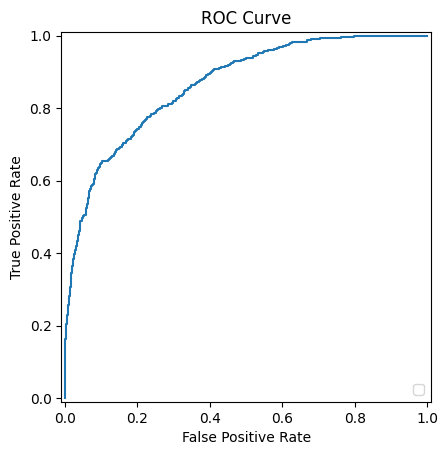

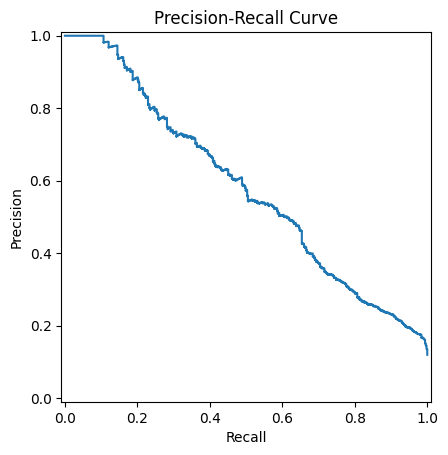

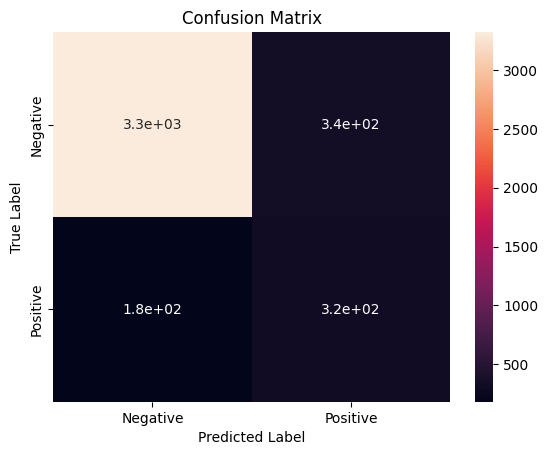

(0.874729502284203,
 0.5481352992194276,
 0.8657796038931569,
 '              precision    recall  f1-score   support\n\n           0       0.95      0.91      0.93      3662\n           1       0.48      0.64      0.55       497\n\n    accuracy                           0.87      4159\n   macro avg       0.72      0.77      0.74      4159\nweighted avg       0.89      0.87      0.88      4159\n',
 0.9139117419910819,
 0.8674382787181297)

In [529]:
train_score_model(XGBClassifier(), X_resampled, X_test, y_resampled, y_test)